In [1]:
! ls -l --block-size=MB

total 835MB
-rw-rw-r-- 1 redanalyze redanalyze   1MB Jun 21 12:53 'BERT - Raw TensorFlow Implementation - Sentiment Analysis.ipynb'
-rw-rw-r-- 1 redanalyze redanalyze   1MB Jun 21 12:53  Untitled.ipynb
-rw-rw-r-- 1 redanalyze redanalyze   1MB Jun 21 11:18  checkpoint
drwxr-xr-x 2 redanalyze redanalyze   1MB Jun 21 10:02  eval
-rw-rw-r-- 1 redanalyze redanalyze 623MB Jun 21 11:18  events.out.tfevents.1561110216.better-eve-instance
-rw-rw-r-- 1 redanalyze redanalyze 193MB Jun 21 11:01  graph.pbtxt
-rw-rw-r-- 1 redanalyze redanalyze  20MB Jun 21 03:12  imdb_movie_reviews.csv.bz2
drwxrwxr-x 3 redanalyze redanalyze   1MB Jun 21 12:55  tf_models


In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import tensorflow_hub as tf_hub
import time
import numpy as np
import os

#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
tf.logging.set_verbosity(tf.logging.INFO)
SEED = 42
np.random.seed(SEED)
tf.set_random_seed(SEED)

W0621 12:58:05.233371 140059782334272 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [3]:
print(tf.__version__)
print(tf_hub.__version__)

1.12.0
0.4.0


In [5]:
dataset = pd.read_csv('./imdb_movie_reviews.csv.bz2', compression='bz2')
dataset['sentiment'] = [1 if sentiment == 'positive' else 0 
                            for sentiment in dataset['sentiment'].values]
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [6]:
DATA_COLUMN = 'review'
LABEL_COLUMN = 'sentiment'
label_list = [0, 1]

train_df = dataset.iloc[:30000]
val_df = dataset.iloc[30000:35000]
test_df = dataset.iloc[35000:]

train_df.shape, val_df.shape, test_df.shape

((30000, 2), (5000, 2), (15000, 2))

In [7]:
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

In [8]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_TFHUB = 'https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1'

def create_tokenizer_from_tfhub_module(tfhub_module):
    """Get the vocab file and casing info from the TF Hub module."""
    g = tf.Graph()
    with g.as_default():
        # we are not fine-tuning BERT layers here
        bert_module = tf_hub.Module(tfhub_module, trainable=False)
        tokenization_info = bert_module(signature="tokenization_info", 
                                        as_dict=True)
        with tf.Session() as sess:
            print('Tokenization info: {}'.format(sess.run(tokenization_info)))
            vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                                  tokenization_info["do_lower_case"]])
    return bert.tokenization.FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_tfhub_module(tfhub_module=BERT_MODEL_TFHUB)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0621 13:00:43.408170 140059782334272 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Tokenization info: {'do_lower_case': True, 'vocab_file': b'/tmp/tfhub_modules/5a395eafef2a37bd9fc55d7f6ae676d2a134a838/assets/vocab.txt'}


In [9]:
def create_model(tfhub_module, is_predicting, input_ids, input_mask, segment_ids, 
                 labels, num_labels, finetune_layers=True):
    """Creates a classification model."""
    
    bert_module = tf_hub.Module(tfhub_module, trainable=finetune_layers)
    
    bert_inputs = dict(input_ids=input_ids,
                       input_mask=input_mask,
                       segment_ids=segment_ids)
    bert_outputs = bert_module(inputs=bert_inputs, signature="tokens",
                               as_dict=True)
    
    # Use "pooled_output" for classification tasks on an entire sentence.
    # Use "sequence_outputs" for token-level output.
    output_layer = bert_outputs["pooled_output"]
    hidden_size = output_layer.shape[-1].value

    # Create our own layer to tune for sentiment data.
    output_weights = tf.get_variable("output_weights", [num_labels, hidden_size],
                                     initializer=tf.glorot_uniform_initializer(seed=SEED))
    output_bias = tf.get_variable("output_bias", [num_labels], initializer=tf.zeros_initializer())
    
    with tf.variable_scope("loss"):
        # Dropout helps prevent overfitting
        output_layer = tf.nn.dropout(output_layer, keep_prob=0.8)
        logits = tf.matmul(output_layer, output_weights, transpose_b=True)
        logits = tf.nn.bias_add(logits, output_bias)
        log_probs = tf.nn.log_softmax(logits, axis=-1)
        
        # Convert labels into one-hot encoding
        one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)
        
        #  get labels from probabilities
        predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
        
        # If we're predicting, we want predicted labels and the probabiltiies.
        if is_predicting:
            return (predicted_labels, log_probs)
        
        # If we're training / evaluating, compute loss between predicted and actual label
        per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
        loss = tf.reduce_mean(per_example_loss)
        
        return (loss, predicted_labels, log_probs)


In [10]:
# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.

def model_fn_builder(tfhub_module, num_labels, learning_rate, num_train_steps, num_warmup_steps,
                     finetune_layers=True):
    """Returns `model_fn` closure for our tf Estimator."""
    
    def model_fn(features, labels, mode, params):  
        """The `model_fn` for tf Estimator."""
        
        input_ids = features["input_ids"]
        input_mask = features["input_mask"]
        segment_ids = features["segment_ids"]
        label_ids = features["label_ids"]

        is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
        # TRAINING and EVALUATION
        if not is_predicting:
            (loss, predicted_labels, log_probs) = create_model(tfhub_module, is_predicting, 
                                                               input_ids, input_mask, segment_ids, 
                                                               label_ids, num_labels, 
                                                               finetune_layers=finetune_layers)
            train_op = bert.optimization.create_optimizer(loss, learning_rate, 
                                                          num_train_steps, num_warmup_steps, 
                                                          use_tpu=False)
            
            # Calculate evaluation metrics. 
            def metric_fn(label_ids, predicted_labels):
                accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
                f1_score = tf.contrib.metrics.f1_score(label_ids, predicted_labels)
                auc = tf.metrics.auc(label_ids, predicted_labels)
                recall = tf.metrics.recall(label_ids, predicted_labels)
                precision = tf.metrics.precision(label_ids, predicted_labels)
                true_pos = tf.metrics.true_positives(label_ids, predicted_labels)
                true_neg = tf.metrics.true_negatives(label_ids, predicted_labels)
                false_pos = tf.metrics.false_positives(label_ids, predicted_labels)
                false_neg = tf.metrics.false_negatives(label_ids, predicted_labels)
                
                return {
                    "eval_accuracy": accuracy,
                    "f1_score": f1_score,
                    "auc": auc,
                    "precision": precision,
                    "recall": recall,
                    "true_positives": true_pos,
                    "true_negatives": true_neg,
                    "false_positives": false_pos,
                    "false_negatives": false_neg
                }
            
            eval_metrics = metric_fn(label_ids, predicted_labels)

            if mode == tf.estimator.ModeKeys.TRAIN:
                return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
            else:
                return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metrics)
            
        else:
            (predicted_labels, log_probs) = create_model(tfhub_module, is_predicting, input_ids, 
                                                         input_mask, segment_ids, 
                                                         label_ids, num_labels, finetune_layers=False)
            
            predictions = {
              'probabilities': log_probs,
              'labels': predicted_labels
            }
            
            return tf.estimator.EstimatorSpec(mode, predictions=predictions)
    
    # Return the actual model function in the closure
    return model_fn

In [11]:
LEARNING_RATE = 2e-5
BATCH_SIZE = 30

# Specify the output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(tf_random_seed=SEED)

model_fn = model_fn_builder(tfhub_module=BERT_MODEL_TFHUB, num_labels=len(label_list),
                            learning_rate=LEARNING_RATE, num_train_steps=0,
                            num_warmup_steps=0, finetune_layers=False)

In [12]:
BERT_MODEL_TFHUB = 'https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1'
MAX_SEQ_LENGTH = 128
label_list = [0, 1]
tokenizer = create_tokenizer_from_tfhub_module(tfhub_module=BERT_MODEL_TFHUB)
test_documents = test_df.review.tolist()
test_labels = test_df.sentiment.tolist()

len(test_documents), len(test_labels)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0621 13:03:34.078605 140059782334272 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Tokenization info: {'do_lower_case': True, 'vocab_file': b'/tmp/tfhub_modules/5a395eafef2a37bd9fc55d7f6ae676d2a134a838/assets/vocab.txt'}


(15000, 15000)

In [13]:
def build_bert_pred_input_examples(documents):
    input_examples = [bert.run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in documents]
    return input_examples


def build_bert_pred_input_features(inp_examples, label_list, max_seq_length, 
                                   tokenizer):
    input_features = (bert.run_classifier
                          .convert_examples_to_features(inp_examples, label_list,
                                                      max_seq_length, tokenizer))
    return input_features


def build_bert_pred_input_function(inp_features, max_seq_length):
    predict_input_fn = (bert.run_classifier
                            .input_fn_builder(features=inp_features, 
                                            seq_length=max_seq_length, 
                                            is_training=False, 
                                            drop_remainder=False))
    return predict_input_fn

In [14]:
test_examples = build_bert_pred_input_examples(test_documents)

test_features = build_bert_pred_input_features(inp_examples=test_examples, label_list=label_list, 
                                               max_seq_length=MAX_SEQ_LENGTH, tokenizer=tokenizer)

predict_input_fn = build_bert_pred_input_function(inp_features=test_features, 
                                                  max_seq_length=MAX_SEQ_LENGTH)

INFO:tensorflow:Writing example 0 of 15000


I0621 13:04:21.333906 140059782334272 tf_logging.py:115] Writing example 0 of 15000


INFO:tensorflow:*** Example ***


I0621 13:04:21.338539 140059782334272 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I0621 13:04:21.340023 140059782334272 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] just don ' t bother . i thought i would see a movie with great su ##ps ##pen ##se and action . < br / > < br / > but it grows boring and terribly predictable after the interesting start . in the middle of the film you have a little social drama and all tension is lost because it slow ##s down the speed . towards the end the it gets better but not really great . i think the director took this movie just too serious . in such a kind of a movie even if u don ' t care about the plot at least you want some nice action . i nearly do ##zed off in the middle / main part [SEP]


I0621 13:04:21.341588 140059782334272 tf_logging.py:115] tokens: [CLS] just don ' t bother . i thought i would see a movie with great su ##ps ##pen ##se and action . < br / > < br / > but it grows boring and terribly predictable after the interesting start . in the middle of the film you have a little social drama and all tension is lost because it slow ##s down the speed . towards the end the it gets better but not really great . i think the director took this movie just too serious . in such a kind of a movie even if u don ' t care about the plot at least you want some nice action . i nearly do ##zed off in the middle / main part [SEP]


INFO:tensorflow:input_ids: 101 2074 2123 1005 1056 8572 1012 1045 2245 1045 2052 2156 1037 3185 2007 2307 10514 4523 11837 3366 1998 2895 1012 1026 7987 1013 1028 1026 7987 1013 1028 2021 2009 7502 11771 1998 16668 21425 2044 1996 5875 2707 1012 1999 1996 2690 1997 1996 2143 2017 2031 1037 2210 2591 3689 1998 2035 6980 2003 2439 2138 2009 4030 2015 2091 1996 3177 1012 2875 1996 2203 1996 2009 4152 2488 2021 2025 2428 2307 1012 1045 2228 1996 2472 2165 2023 3185 2074 2205 3809 1012 1999 2107 1037 2785 1997 1037 3185 2130 2065 1057 2123 1005 1056 2729 2055 1996 5436 2012 2560 2017 2215 2070 3835 2895 1012 1045 3053 2079 5422 2125 1999 1996 2690 1013 2364 2112 102


I0621 13:04:21.342924 140059782334272 tf_logging.py:115] input_ids: 101 2074 2123 1005 1056 8572 1012 1045 2245 1045 2052 2156 1037 3185 2007 2307 10514 4523 11837 3366 1998 2895 1012 1026 7987 1013 1028 1026 7987 1013 1028 2021 2009 7502 11771 1998 16668 21425 2044 1996 5875 2707 1012 1999 1996 2690 1997 1996 2143 2017 2031 1037 2210 2591 3689 1998 2035 6980 2003 2439 2138 2009 4030 2015 2091 1996 3177 1012 2875 1996 2203 1996 2009 4152 2488 2021 2025 2428 2307 1012 1045 2228 1996 2472 2165 2023 3185 2074 2205 3809 1012 1999 2107 1037 2785 1997 1037 3185 2130 2065 1057 2123 1005 1056 2729 2055 1996 5436 2012 2560 2017 2215 2070 3835 2895 1012 1045 3053 2079 5422 2125 1999 1996 2690 1013 2364 2112 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0621 13:04:21.345009 140059782334272 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0621 13:04:21.346504 140059782334272 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I0621 13:04:21.347896 140059782334272 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I0621 13:04:21.353489 140059782334272 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I0621 13:04:21.354552 140059782334272 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] be careful with this one . once you get yer mit ##ts on it , it ' ll change the way you look at kung - fu flick ##s . you will be yearning a plot from all of the kung - fu films now , you will be wanting character depth and development , you will be craving mystery and un ##pre ##dict ##ability , you will demand dynamic camera work and incredible backdrop ##s . sadly , you won ' t find all of these aspects together in one kung - fu movie , except for five deadly venom ##s ! < br / > < br / > easily the best kung - fu movie of all - time , venom ##s blend [SEP]


I0621 13:04:21.356034 140059782334272 tf_logging.py:115] tokens: [CLS] be careful with this one . once you get yer mit ##ts on it , it ' ll change the way you look at kung - fu flick ##s . you will be yearning a plot from all of the kung - fu films now , you will be wanting character depth and development , you will be craving mystery and un ##pre ##dict ##ability , you will demand dynamic camera work and incredible backdrop ##s . sadly , you won ' t find all of these aspects together in one kung - fu movie , except for five deadly venom ##s ! < br / > < br / > easily the best kung - fu movie of all - time , venom ##s blend [SEP]


INFO:tensorflow:input_ids: 101 2022 6176 2007 2023 2028 1012 2320 2017 2131 20416 10210 3215 2006 2009 1010 2009 1005 2222 2689 1996 2126 2017 2298 2012 18577 1011 11865 17312 2015 1012 2017 2097 2022 29479 1037 5436 2013 2035 1997 1996 18577 1011 11865 3152 2085 1010 2017 2097 2022 5782 2839 5995 1998 2458 1010 2017 2097 2022 26369 6547 1998 4895 28139 29201 8010 1010 2017 2097 5157 8790 4950 2147 1998 9788 18876 2015 1012 13718 1010 2017 2180 1005 1056 2424 2035 1997 2122 5919 2362 1999 2028 18577 1011 11865 3185 1010 3272 2005 2274 9252 15779 2015 999 1026 7987 1013 1028 1026 7987 1013 1028 4089 1996 2190 18577 1011 11865 3185 1997 2035 1011 2051 1010 15779 2015 12586 102


I0621 13:04:21.356955 140059782334272 tf_logging.py:115] input_ids: 101 2022 6176 2007 2023 2028 1012 2320 2017 2131 20416 10210 3215 2006 2009 1010 2009 1005 2222 2689 1996 2126 2017 2298 2012 18577 1011 11865 17312 2015 1012 2017 2097 2022 29479 1037 5436 2013 2035 1997 1996 18577 1011 11865 3152 2085 1010 2017 2097 2022 5782 2839 5995 1998 2458 1010 2017 2097 2022 26369 6547 1998 4895 28139 29201 8010 1010 2017 2097 5157 8790 4950 2147 1998 9788 18876 2015 1012 13718 1010 2017 2180 1005 1056 2424 2035 1997 2122 5919 2362 1999 2028 18577 1011 11865 3185 1010 3272 2005 2274 9252 15779 2015 999 1026 7987 1013 1028 1026 7987 1013 1028 4089 1996 2190 18577 1011 11865 3185 1997 2035 1011 2051 1010 15779 2015 12586 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0621 13:04:21.358808 140059782334272 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0621 13:04:21.360312 140059782334272 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I0621 13:04:21.361347 140059782334272 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I0621 13:04:21.366170 140059782334272 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I0621 13:04:21.367263 140059782334272 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] chili palmer is tired of doing movies and know wants to do some success in music . being half ma ##fi ##oso half expert ne ##go ##tia ##tor , he wants to rise in the music market . however , know everyone is like him and making the good singer linda moon to record a hit will be harder as expected . the first part is funny and filled with irony , this one falls into the easy jokes and has many less good moments . only the two women ( um ##a and mil ##ian ) are decent in their part . most of the film is done with his ##tri ##onic character , excessive ##ly exaggerated ( a little is ok , too much [SEP]


I0621 13:04:21.368298 140059782334272 tf_logging.py:115] tokens: [CLS] chili palmer is tired of doing movies and know wants to do some success in music . being half ma ##fi ##oso half expert ne ##go ##tia ##tor , he wants to rise in the music market . however , know everyone is like him and making the good singer linda moon to record a hit will be harder as expected . the first part is funny and filled with irony , this one falls into the easy jokes and has many less good moments . only the two women ( um ##a and mil ##ian ) are decent in their part . most of the film is done with his ##tri ##onic character , excessive ##ly exaggerated ( a little is ok , too much [SEP]


INFO:tensorflow:input_ids: 101 20238 8809 2003 5458 1997 2725 5691 1998 2113 4122 2000 2079 2070 3112 1999 2189 1012 2108 2431 5003 8873 19137 2431 6739 11265 3995 10711 4263 1010 2002 4122 2000 4125 1999 1996 2189 3006 1012 2174 1010 2113 3071 2003 2066 2032 1998 2437 1996 2204 3220 8507 4231 2000 2501 1037 2718 2097 2022 6211 2004 3517 1012 1996 2034 2112 2003 6057 1998 3561 2007 19728 1010 2023 2028 4212 2046 1996 3733 13198 1998 2038 2116 2625 2204 5312 1012 2069 1996 2048 2308 1006 8529 2050 1998 23689 2937 1007 2024 11519 1999 2037 2112 1012 2087 1997 1996 2143 2003 2589 2007 2010 18886 12356 2839 1010 11664 2135 16903 1006 1037 2210 2003 7929 1010 2205 2172 102


I0621 13:04:21.369133 140059782334272 tf_logging.py:115] input_ids: 101 20238 8809 2003 5458 1997 2725 5691 1998 2113 4122 2000 2079 2070 3112 1999 2189 1012 2108 2431 5003 8873 19137 2431 6739 11265 3995 10711 4263 1010 2002 4122 2000 4125 1999 1996 2189 3006 1012 2174 1010 2113 3071 2003 2066 2032 1998 2437 1996 2204 3220 8507 4231 2000 2501 1037 2718 2097 2022 6211 2004 3517 1012 1996 2034 2112 2003 6057 1998 3561 2007 19728 1010 2023 2028 4212 2046 1996 3733 13198 1998 2038 2116 2625 2204 5312 1012 2069 1996 2048 2308 1006 8529 2050 1998 23689 2937 1007 2024 11519 1999 2037 2112 1012 2087 1997 1996 2143 2003 2589 2007 2010 18886 12356 2839 1010 11664 2135 16903 1006 1037 2210 2003 7929 1010 2205 2172 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0621 13:04:21.371129 140059782334272 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0621 13:04:21.372383 140059782334272 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I0621 13:04:21.373336 140059782334272 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I0621 13:04:21.386667 140059782334272 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I0621 13:04:21.388248 140059782334272 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] following is a little - known 1998 british film , which was made with a budget of £ ##80 ##00 and has a running time of 70 minutes . when watching it , you ' d never expect its director to go on to make it in hollywood and become one of the most acclaimed and celebrated directors of the 21st century well , everybody has to start somewhere i suppose . < br / > < br / > the director of following , as you probably already know is englishman christopher nolan , who directly after following would go on to direct the critically - acclaimed independent film me ##mento ; a few years later he would be hired by warner bros . to [SEP]


I0621 13:04:21.389198 140059782334272 tf_logging.py:115] tokens: [CLS] following is a little - known 1998 british film , which was made with a budget of £ ##80 ##00 and has a running time of 70 minutes . when watching it , you ' d never expect its director to go on to make it in hollywood and become one of the most acclaimed and celebrated directors of the 21st century well , everybody has to start somewhere i suppose . < br / > < br / > the director of following , as you probably already know is englishman christopher nolan , who directly after following would go on to direct the critically - acclaimed independent film me ##mento ; a few years later he would be hired by warner bros . to [SEP]


INFO:tensorflow:input_ids: 101 2206 2003 1037 2210 1011 2124 2687 2329 2143 1010 2029 2001 2081 2007 1037 5166 1997 1069 17914 8889 1998 2038 1037 2770 2051 1997 3963 2781 1012 2043 3666 2009 1010 2017 1005 1040 2196 5987 2049 2472 2000 2175 2006 2000 2191 2009 1999 5365 1998 2468 2028 1997 1996 2087 10251 1998 6334 5501 1997 1996 7398 2301 2092 1010 7955 2038 2000 2707 4873 1045 6814 1012 1026 7987 1013 1028 1026 7987 1013 1028 1996 2472 1997 2206 1010 2004 2017 2763 2525 2113 2003 25244 5696 13401 1010 2040 3495 2044 2206 2052 2175 2006 2000 3622 1996 11321 1011 10251 2981 2143 2033 23065 1025 1037 2261 2086 2101 2002 2052 2022 5086 2011 6654 10243 1012 2000 102


I0621 13:04:21.390362 140059782334272 tf_logging.py:115] input_ids: 101 2206 2003 1037 2210 1011 2124 2687 2329 2143 1010 2029 2001 2081 2007 1037 5166 1997 1069 17914 8889 1998 2038 1037 2770 2051 1997 3963 2781 1012 2043 3666 2009 1010 2017 1005 1040 2196 5987 2049 2472 2000 2175 2006 2000 2191 2009 1999 5365 1998 2468 2028 1997 1996 2087 10251 1998 6334 5501 1997 1996 7398 2301 2092 1010 7955 2038 2000 2707 4873 1045 6814 1012 1026 7987 1013 1028 1026 7987 1013 1028 1996 2472 1997 2206 1010 2004 2017 2763 2525 2113 2003 25244 5696 13401 1010 2040 3495 2044 2206 2052 2175 2006 2000 3622 1996 11321 1011 10251 2981 2143 2033 23065 1025 1037 2261 2086 2101 2002 2052 2022 5086 2011 6654 10243 1012 2000 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0621 13:04:21.391484 140059782334272 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0621 13:04:21.392612 140059782334272 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I0621 13:04:21.393316 140059782334272 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I0621 13:04:21.396054 140059782334272 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I0621 13:04:21.396872 140059782334272 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] dark angel is a cross between hu ##xley ' s brave new world and percy ' s love in the ruins - - portraying the not too distant future as a disturbing mixture of chaos and order , both in the worst sense of the word . once one swallows the premise that all modern technology can be brought to a stands ##till by " the pulse , " it provides an entertaining landscape for exploring the personalities of and relationships between the two primary characters - - max ( the dark angel / bike messenger ) and logan ( the rich rebel ) . it seems uneven , perhaps a result of a variety of authors , but is held together by the energetic , [SEP]


I0621 13:04:21.397887 140059782334272 tf_logging.py:115] tokens: [CLS] dark angel is a cross between hu ##xley ' s brave new world and percy ' s love in the ruins - - portraying the not too distant future as a disturbing mixture of chaos and order , both in the worst sense of the word . once one swallows the premise that all modern technology can be brought to a stands ##till by " the pulse , " it provides an entertaining landscape for exploring the personalities of and relationships between the two primary characters - - max ( the dark angel / bike messenger ) and logan ( the rich rebel ) . it seems uneven , perhaps a result of a variety of authors , but is held together by the energetic , [SEP]


INFO:tensorflow:input_ids: 101 2601 4850 2003 1037 2892 2090 15876 20959 1005 1055 9191 2047 2088 1998 11312 1005 1055 2293 1999 1996 8435 1011 1011 17274 1996 2025 2205 6802 2925 2004 1037 14888 8150 1997 8488 1998 2344 1010 2119 1999 1996 5409 3168 1997 1996 2773 1012 2320 2028 26436 1996 18458 2008 2035 2715 2974 2064 2022 2716 2000 1037 4832 28345 2011 1000 1996 8187 1010 1000 2009 3640 2019 14036 5957 2005 11131 1996 12857 1997 1998 6550 2090 1996 2048 3078 3494 1011 1011 4098 1006 1996 2601 4850 1013 7997 11981 1007 1998 6307 1006 1996 4138 8443 1007 1012 2009 3849 17837 1010 3383 1037 2765 1997 1037 3528 1997 6048 1010 2021 2003 2218 2362 2011 1996 18114 1010 102


I0621 13:04:21.400209 140059782334272 tf_logging.py:115] input_ids: 101 2601 4850 2003 1037 2892 2090 15876 20959 1005 1055 9191 2047 2088 1998 11312 1005 1055 2293 1999 1996 8435 1011 1011 17274 1996 2025 2205 6802 2925 2004 1037 14888 8150 1997 8488 1998 2344 1010 2119 1999 1996 5409 3168 1997 1996 2773 1012 2320 2028 26436 1996 18458 2008 2035 2715 2974 2064 2022 2716 2000 1037 4832 28345 2011 1000 1996 8187 1010 1000 2009 3640 2019 14036 5957 2005 11131 1996 12857 1997 1998 6550 2090 1996 2048 3078 3494 1011 1011 4098 1006 1996 2601 4850 1013 7997 11981 1007 1998 6307 1006 1996 4138 8443 1007 1012 2009 3849 17837 1010 3383 1037 2765 1997 1037 3528 1997 6048 1010 2021 2003 2218 2362 2011 1996 18114 1010 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0621 13:04:21.401564 140059782334272 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0621 13:04:21.402629 140059782334272 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I0621 13:04:21.403728 140059782334272 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:Writing example 10000 of 15000


I0621 13:04:57.783702 140059782334272 tf_logging.py:115] Writing example 10000 of 15000


In [15]:
estimator = tf.estimator.Estimator(model_fn=model_fn, config=run_config,
                                   params={"batch_size": BATCH_SIZE})
predictions = [pred for pred in estimator.predict(predict_input_fn, 
                                                  checkpoint_path="./tf_models/sentiment_v1/model.ckpt-5000")]

W0621 13:06:31.781743 140059782334272 tf_logging.py:125] Using temporary folder as model directory: /tmp/tmpj0glu3a3


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpj0glu3a3', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f61a3754f28>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0621 13:06:31.784746 140059782334272 tf_logging.py:115] Using config: {'_model_dir': '/tmp/tmpj0glu3a3', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f61a3754f28>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0621 13:06:38.407441 140059782334272 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0621 13:06:41.834465 140059782334272 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0621 13:06:41.955253 140059782334272 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0621 13:06:42.453446 140059782334272 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Restoring parameters from ./tf_models/sentiment_v1/model.ckpt-5000


I0621 13:06:42.459108 140059782334272 tf_logging.py:115] Restoring parameters from ./tf_models/sentiment_v1/model.ckpt-5000


INFO:tensorflow:Running local_init_op.


I0621 13:06:43.464135 140059782334272 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0621 13:06:43.533412 140059782334272 tf_logging.py:115] Done running local_init_op.


In [16]:
predictions[:5]

[{'probabilities': array([-6.6754976e-05, -9.6146030e+00], dtype=float32),
  'labels': 0},
 {'probabilities': array([-9.754098e+00, -5.805324e-05], dtype=float32),
  'labels': 1},
 {'probabilities': array([-4.17231649e-06, -1.23868885e+01], dtype=float32),
  'labels': 0},
 {'probabilities': array([-5.4796185e+00, -4.1796714e-03], dtype=float32),
  'labels': 1},
 {'probabilities': array([-1.16084795e+01, -9.05986508e-06], dtype=float32),
  'labels': 1}]

In [17]:
predictions[0]['labels'], np.exp(predictions[0]['probabilities'])

(0, array([9.9993324e-01, 6.6746878e-05], dtype=float32))

In [18]:
from sklearn.metrics import confusion_matrix, classification_report

test_predictions = [pred['labels'] for pred in predictions]
print('Classification Report:')
print(classification_report(y_true=test_labels, y_pred=test_predictions))

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      7490
           1       0.88      0.90      0.89      7510

    accuracy                           0.89     15000
   macro avg       0.89      0.89      0.89     15000
weighted avg       0.89      0.89      0.89     15000



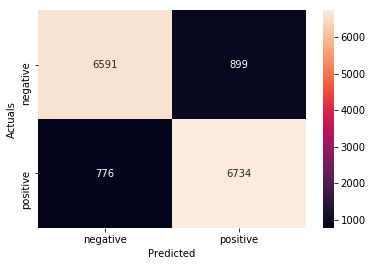

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

with tf.Session() as session:
    cm = tf.confusion_matrix(test_labels, test_predictions).eval()

LABELS = ['negative', 'positive']
sns.heatmap(cm, annot=True, xticklabels=LABELS, yticklabels=LABELS, fmt='g')
xl = plt.xlabel("Predicted")
yl = plt.ylabel("Actuals")